In [1]:
import os
import numpy as np
import seaborn as sns
import wandb
#from wandb.keras import WandbCallback
from keras import callbacks
import keras
from keras import regularizers
import DeepSetNeuralNetArchitecture as DSNNA
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from DeepSetNeuralNetArchitecture import Mean_Squared_Error
from HffragDeepSetsProjectionMultivariate import DeepSetsProjection
from sklearn.feature_selection import mutual_info_regression
import keras.backend as k
import uproot
import awkward as ak
import sklearn as sk
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import pandas as pd
from hffrag import fixedbinning
from hffrag import binneddensity
from keras.utils.vis_utils import plot_model
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

2023-02-17 15:07:33.372257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 15:07:33.519256: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-17 15:07:33.523440: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-17 15:07:33.523455: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

number of jets to train on:
141329


/home/physics/phujdj/DeepLearningParticlePhysics/hffrag.py:136: RuntimeWarning: overflow encountered in sinh
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))


In [2]:
plt.style.use("default")
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rc('text',usetex = False)
plt.rc('font',family = 'Times New Roman')

In [3]:
# The data is being stored in a tree datastructure.
# We access the charm root using this command
tree = uproot.open("/storage/epp2/phswmv/data/hffrag/hffrag.root:CharmAnalysis")

In [4]:
# Initial parameters
MASKVAL = -999 # This value is introduced to ensure arrays are regular (Of the same size). They will be masked later by the network
MAXTRACKS = 32 # This value is the maximum number of tracks allowed per event
BATCHSIZE = 64 # This is the batch size of the mini batches used during training
EPOCHS = 1000 # This is the default number of epochs for which the neural network will train providing that early stopping does not occur
MAXEVENTS = 2e5 #This is the maximum number of events that will the program will accept
LR = 1e-4 #This is the default learning rate

In [5]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                  "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi", "AnalysisAntiKt4TruthJets_m","AnalysisAntiKt4TruthJets_ghostB_pdgId",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi", "AnalysisAntiKt4TruthJets_ghostB_m"]
SV_features = ["TruthParticles_Selected_LxyT"]

In [6]:
# Read in the data from the root file
features = tree.arrays(jet_features+track_features + SV_features, entry_stop=MAXEVENTS)

In [7]:
# Select the events of interest
events = features[ak.sum(
    features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]

In [8]:
# Displays the number of jets being trained on
jets = events[jet_features][:, 0]
print("The number of jets to train on is: ", len(jets))
print("The number of track features is: ",len(track_features))

The number of jets to train on is:  199840
The number of track features is:  8


In [9]:
# Select tracks from the events
tracks = events[track_features]
Secondary_Displacement_temp_first = events[SV_features]

# Match the tracks to the jets
mask = DSNNA.Match_Tracks(jets, tracks)
matchedtracks = tracks[mask]

# Pad and Flatten the data
matchedtracks = DSNNA.flatten(matchedtracks, MAXTRACKS)

In [10]:
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
Secondary_Displacement_temp_a = DSNNA.flatten(Secondary_Displacement_temp_first, 6).to_numpy()
Secondary_Displacement_temp_b = Secondary_Displacement_temp_a[:,0]
Secondary_Displacement_temp = Secondary_Displacement_temp_b[bjets]
jets = jets[bjets]

# Obtain the pt, eta and phi of each b hadron jet
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()
bhads_m = jets["AnalysisAntiKt4TruthJets_ghostB_m"][:,0].to_numpy()
bhads_PGID = jets["AnalysisAntiKt4TruthJets_ghostB_pdgId"][:,0].to_numpy()

jets_pt = jets["AnalysisAntiKt4TruthJets_pt"].to_numpy()
jets_eta = jets["AnalysisAntiKt4TruthJets_eta"].to_numpy()
jets_phi = jets["AnalysisAntiKt4TruthJets_phi"].to_numpy()
jets_m = jets["AnalysisAntiKt4TruthJets_m"].to_numpy()
b_jets = np.stack([jets_pt,jets_eta,jets_phi, jets_m], axis = -1)

bhads = np.stack([bhads_pt,bhads_eta,bhads_phi, bhads_m],axis = -1) #Combine the momentum, eta and phi for each jet into one array

print("There are {} outputs".format(np.shape(bhads)[1])) # Display the number of target features the neural network will predict
matchedtracks = matchedtracks[bjets]
print("There are {} inputs".format(np.shape(matchedtracks)[1])) # Display the number of target features the neural network will use in it's predictions

There are 4 outputs
There are 32 inputs


In [11]:
Secondary_Displacement = np.array([x[0] for x in Secondary_Displacement_temp])
print(np.min(Secondary_Displacement), np.max(Secondary_Displacement))

-999.0 115.98360443115234


In [12]:
# Transform the jet and tracks to unstructed data.
jets = structured_to_unstructured(jets[jet_features[:-5]])
matchedtracks = structured_to_unstructured(matchedtracks)

In [13]:
# Convert the coordinates of the b jets and tracks to cartesian coordinates
polartracks = matchedtracks.to_numpy()
Num_events = MAXTRACKS
tracks_pt = polartracks[:,:,0].reshape(-1,Num_events,1)
tracks_eta = polartracks[:,:,1].reshape(-1,Num_events,1)
tracks_phi = polartracks[:,:,2].reshape(-1,Num_events,1)

tracks_pep = np.concatenate([tracks_pt,tracks_eta,tracks_phi], axis = -1) 
print(tracks_pep.shape)

jets_pt = b_jets[:,0].reshape(-1,1)
jets_eta = b_jets[:,1].reshape(-1,1)
jets_phi = b_jets[:,2].reshape(-1,1)

b_jets_pep = np.concatenate([jets_pt,jets_eta,jets_phi], axis = -1) 
print(b_jets_pep.shape)

tracks_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
bhads = DSNNA.pt_eta_phi_2_px_py_pz_jets(bhads)
b_jets_p = DSNNA.pt_eta_phi_2_px_py_pz_jets(b_jets)
b_jets_m = b_jets[:,-1].reshape(-1,1)

#Combine the momenta of the tracks with the rest of the track features to form the track dataset
tracks = np.concatenate([tracks_p,tracks_pep,matchedtracks[:,:,3:].to_numpy()],axis = 2)
b_jets = np.concatenate([b_jets_p,b_jets_pep,b_jets_m] ,axis = 1)

(96659, 32, 3)
(96659, 3)


/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py:108: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


In [14]:
tracks = np.ma.masked_values(tracks,-999)
Secondary_Displacement = np.ma.masked_values(Secondary_Displacement,-999)

In [15]:
bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
bhads_fractions = np.stack([bhads_fractions_px,bhads_fractions_py, bhads_fractions_pz], axis = -1)
bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
print(bhads_fractions_px.shape)

(96659,)


In [16]:
Tracks_Momentum = np.sqrt(tracks[:, : ,0]**2 + tracks[:,:,1]**2 + tracks[:,:,2]**2)
Tracks_4_Momentum = np.stack([Tracks_Momentum, tracks[:,:,0], tracks[:,:,1], tracks[:,:,2]], axis = -1)
print(Tracks_4_Momentum.shape)
Tracks_Invariant_Mass = np.sqrt((np.sum(Tracks_4_Momentum, axis = 1) * np.sum(Tracks_4_Momentum, axis = 1)).sum(axis = -1))
print(Tracks_Invariant_Mass.shape)

/tmp/ipykernel_15737/381760229.py:1: RuntimeWarning: invalid value encountered in sqrt
  Tracks_Momentum = np.sqrt(tracks[:, : ,0]**2 + tracks[:,:,1]**2 + tracks[:,:,2]**2)


(96659, 32, 4)
(96659,)


In [17]:
Secondary_Displacement = np.ma.masked_values(Secondary_Displacement,-999)

In [18]:
b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
bhads_mag = np.linalg.norm(bhads[:,:3], axis = 1)
tracks_Momentum = np.sum(np.linalg.norm(tracks[:,:,:3], axis = 2))

bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
bhads_fractions_pt = bhads_pt/b_jets_pep[:,0]
print(bhads_fractions_px.shape)
print(bhads_fractions_px.shape)

b_jets_energy = np.sqrt((b_jets_m[:,0]**2) + (b_jets_mag**2))
print(b_jets_energy.shape, b_jets_m.shape)

b_jets_energy_pt = np.sqrt((b_jets_m[:,0]**2) + (b_jets[:,4]**2))
b_jets_energy_pt.shape

b_jet_energy_mass_ratio = b_jets_energy/b_jets_m[:,0]

print(b_jet_energy_mass_ratio.shape)
bhads_energy = np.sqrt((bhads_m**2) + (bhads_mag**2))
bhads_energy.shape

bhads_energy_mass_ratio = bhads_energy/bhads_m

print(bhads_fractions[0])
print(bhads[0,0]/b_jets[0,0])
print(np.min(bhads_fractions),np.max(bhads_fractions))

print(bhads_fractions_px[0])
print(bhads[0,0]/b_jets[0,0])
print(np.min(bhads_fractions_px),np.max(bhads_fractions_px))

print("Hello")
sum_px_tracks = np.sum(tracks[:,:,0], axis = 1)
sum_py_tracks = np.sum(tracks[:,:,1], axis = 1)
sum_pz_tracks = np.sum(tracks[:,:,2], axis = 1)
sum_pt_tracks = np.sum(tracks[:,:,3], axis = 1)
print(sum_pt_tracks.shape)

sum_px_tracks_RSE = np.sqrt(np.sum(tracks[:,:,0]**2, axis = 1))
sum_py_tracks_RSE= np.sqrt(np.sum(tracks[:,:,1]**2, axis = 1))
sum_pz_tracks_RSE = np.sqrt(np.sum(tracks[:,:,2]**2, axis = 1))
sum_pt_tracks_RSE = np.sqrt(np.sum(tracks[:,:,3]**2, axis = 1))
print(sum_pt_tracks_RSE.shape)

RSM_scaled_px = sum_px_tracks_RSE/sum_px_tracks
RSM_scaled_py = sum_py_tracks_RSE/sum_py_tracks
RSM_scaled_pz = sum_pz_tracks_RSE/sum_pz_tracks
RSM_scaled_pt = sum_pt_tracks_RSE/sum_pt_tracks
print(RSM_scaled_pt.shape)

RMS_scaled_px = np.sqrt(np.sum(tracks[:,:,0]**2, axis = 1)/MAXTRACKS)
RMS_scaled_py = np.sqrt(np.sum(tracks[:,:,1]**2, axis = 1)/MAXTRACKS)
RMS_scaled_pz = np.sqrt(np.sum(tracks[:,:,2]**2, axis = 1)/MAXTRACKS)
RMS_scaled_pt = np.sqrt(np.sum(tracks[:,:,3]**2, axis = 1)/MAXTRACKS)
print(RMS_scaled_pt.shape)

Log_px_tracks = np.log(abs(tracks[:,:,0]/b_jets[:,np.newaxis,0]))
Log_py_tracks = np.log(abs(tracks[:,:,1]/b_jets[:,np.newaxis,1]))
Log_pz_tracks = np.log(abs(tracks[:,:,2]/b_jets[:,np.newaxis,2]))
Log_pt_tracks = np.log(abs(tracks[:,:,3]/b_jets[:,np.newaxis,3]))
Log_tracks = np.stack([Log_px_tracks, Log_py_tracks, Log_pz_tracks, Log_pt_tracks], axis = -1)

Log_Sum_px = np.log(sum_px_tracks/b_jets[:,0])
Log_Sum_py = np.log(sum_py_tracks/b_jets[:,1])
Log_Sum_pz = np.log(sum_pz_tracks/b_jets[:,2])
Log_Sum_pt = np.log(sum_pt_tracks/b_jets[:,3])
Log_Momenta = np.log(abs(tracks_Momentum/np.sum(b_jets[:,:3], axis = 1)))
print(Log_Sum_pt.shape)

tracks_fractions_px = tracks[:,:,0]/b_jets[:,np.newaxis,0]
tracks_fractions_py = tracks[:,:,1]/b_jets[:,np.newaxis,1]
tracks_fractions_pz = tracks[:,:,2]/b_jets[:,np.newaxis,2]
tracks_fractions_pt = tracks[:,:,3]/b_jets[:,np.newaxis,3]
print(tracks_fractions_pt.shape)
Track_fractions = np.stack([tracks_fractions_px,tracks_fractions_py, tracks_fractions_pz], axis = -1)
print(Track_fractions.shape)

print(Track_fractions.shape)
print(tracks[0,0,0]/b_jets[0,0])
print(np.mean(Track_fractions),np.std(Track_fractions))

print("hey")
Tracks_projection = ((tracks[:,:,:3]*b_jets[:,np.newaxis,:3]).sum(axis = 2)/(b_jets_mag[:,np.newaxis]**2))
print(Tracks_projection.shape)
Track_Momenta = np.stack([sum_px_tracks, sum_py_tracks, sum_pz_tracks], axis = -1)
print(Track_Momenta.shape)
Sum_Tracks_projection = ((Track_Momenta*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
print(Sum_Tracks_projection.shape)

b_jet_energy_ratio_px = sum_px_tracks/b_jets_energy
b_jet_energy_ratio_py = sum_py_tracks/b_jets_energy
b_jet_energy_ratio_pz = sum_pz_tracks/b_jets_energy
b_jet_energy_ratio_pt = sum_pt_tracks/b_jets_energy
print(b_jet_energy_ratio_pt.shape)

b_jet_energy_ratio_cart = b_jets_mag/b_jets_energy
b_jet_energy_ratio_pt = b_jets[:,4]/b_jets_energy
print(b_jet_energy_ratio_pt.shape)

b_jet_energy_ratio_total = np.sum(b_jets[:,4])/np.sum(b_jets_energy)  
b_jet_transverse_mass = np.sqrt(b_jets_energy**2 - b_jets[:,2]**2)
bhads_transverse_mass = np.sqrt(bhads_energy**2 - bhads[:,2]**2)
print(b_jet_transverse_mass[0])
print(b_jet_energy_ratio_total.shape)
print(b_jet_transverse_mass.shape)
print(np.full((len(b_jets)),b_jet_energy_ratio_total).shape)
print("end")
bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)

print(np.mean(b_jets_energy),np.std(b_jets_energy))

b_jets = np.stack([b_jets[:,0], b_jets[:,1], b_jets[:,2],b_jets[:,3],b_jets[:,4], b_jets[:,5], b_jets[:,6], b_jets_mag, sum_px_tracks, sum_py_tracks, sum_pz_tracks, sum_pt_tracks, sum_px_tracks_RSE, sum_py_tracks_RSE, sum_pz_tracks_RSE, sum_pt_tracks_RSE, RSM_scaled_px, RSM_scaled_py, RSM_scaled_pz, RSM_scaled_pt, RMS_scaled_px, RMS_scaled_py, RMS_scaled_pz, RMS_scaled_pt, b_jet_transverse_mass, Log_Sum_px, Log_Sum_py, Log_Sum_pz, Log_Sum_pt, Log_Momenta, b_jets_energy, b_jet_energy_ratio_px, b_jet_energy_ratio_py, b_jet_energy_ratio_pz, b_jet_energy_ratio_cart, b_jet_energy_ratio_pt, b_jet_energy_mass_ratio, np.full((len(b_jets),),b_jet_energy_ratio_total)], axis = -1)
bhads_targets = np.stack([bhads[:,0]/1e6,bhads[:,1]/1e6, bhads[:,2]/1e6, bhads_pt/1e6, bhads_eta, bhads_phi, bhads_energy/1e6, bhads_fractions_pt, bhads_transverse_mass/1e6, bhads_energy_mass_ratio/1e3, bhads_projection, bhads_m/1e3, Secondary_Displacement/1e4], axis = -1)

(96659,)
(96659,)
(96659,) (96659, 1)
(96659,)
[0.9923946  1.00824593 0.99120818]
0.9923945992521676
-34465.39587820514 618.1237235802715
0.9923945992521676
0.9923945992521676
-4195.466731248074 618.1237235802715
Hello
(96659,)


/tmp/ipykernel_15737/2583003470.py:18: RuntimeWarning: divide by zero encountered in true_divide
  b_jet_energy_mass_ratio = b_jets_energy/b_jets_m[:,0]


(96659,)
(96659,)
(96659,)


/tmp/ipykernel_15737/2583003470.py:65: RuntimeWarning: divide by zero encountered in log
  Log_Sum_px = np.log(sum_px_tracks/b_jets[:,0])
/tmp/ipykernel_15737/2583003470.py:65: RuntimeWarning: invalid value encountered in log
  Log_Sum_px = np.log(sum_px_tracks/b_jets[:,0])
/tmp/ipykernel_15737/2583003470.py:66: RuntimeWarning: divide by zero encountered in log
  Log_Sum_py = np.log(sum_py_tracks/b_jets[:,1])
/tmp/ipykernel_15737/2583003470.py:66: RuntimeWarning: invalid value encountered in log
  Log_Sum_py = np.log(sum_py_tracks/b_jets[:,1])
/tmp/ipykernel_15737/2583003470.py:67: RuntimeWarning: divide by zero encountered in log
  Log_Sum_pz = np.log(sum_pz_tracks/b_jets[:,2])
/tmp/ipykernel_15737/2583003470.py:67: RuntimeWarning: invalid value encountered in log
  Log_Sum_pz = np.log(sum_pz_tracks/b_jets[:,2])
/tmp/ipykernel_15737/2583003470.py:68: RuntimeWarning: divide by zero encountered in log
  Log_Sum_pt = np.log(sum_pt_tracks/b_jets[:,3])


(96659,)
(96659, 32)
(96659, 32, 3)
(96659, 32, 3)
0.14894195156291137
-670.9594413217917 469.1820966775337
hey
(96659, 32)
(96659, 3)
(96659,)
(96659,)
(96659,)
79564.74
()
(96659,)
(96659,)
end
215380.48 189104.06


In [19]:
bhads_targets = np.ma.masked_values(bhads_targets, -999)
np.min(bhads_projection), np.max(bhads_projection)

(0.007714192445469887, 3.841544124624852)

In [20]:
"""
0 - Momentum Px 
1 - Momentum Py
2 - Momentum Pz
3 - Momentum Pt
4 - Total Momentum
5-  Momentum Eta Scaled
6 - Momentum Phi Scaled
7 - Tranvserse Impact parameter sin component
8 - Longitudinal Impact parameter
9 - Longitudinal Impact parameter signficiance
10 - Longitudinal Impact Parameter w.r.t PV
11 - Longitudinal Impact Parameter wr.r.t PV
12 - Momentum Fraction Px Scaled
13 - Momentum Fraction Py Scaled
14 - Momentum Fraction Pz Scaled
16 - Momentum Fraction pt Scaled.
17 - Logarithm of px of the tracks / b_jet x momenta
18 - Logarithm of py of the tracks / b_jet y momenta
19 - Logarithm of pz of the tracks / b_jet z momenta
20 - Logarithm of sum pt of the tracks / b_jet t momenta
"""
Tracks_input = np.concatenate([tracks, Tracks_4_Momentum[:,:,0].reshape(-1,32,1), Track_fractions, Log_tracks], axis = -1)
print(Tracks_input.shape)

(96659, 32, 19)


In [21]:
"""
0 - Momentum Px Scaled
1 - Momentum Py Scaled
2 - Momentum Pz Scaled
3 - Momentum Pt Scaled
4 - Momentum eta Scaled
5 - Momentum Phi Scaled
6 - Sum px of the tracks
7 - Sum py of the tracks
8 - Sum pz of the tracks
9 - Sum pt of the tracks
10 - Sqrt of the Sum px of the tracks
11 - Sqrt of the Sum py of the tracks
12 - Sqrt of the Sum pz of the tracks
13 - Sqrt of the Sum pt of the tracks
14 - Sqrt of the Sum px of the tracks scaled by the sum px of the tracks
15 - Sqrt of the Sum py of the tracks scaled by the sum py of the tracks
16 - Sqrt of the Sum pz of the tracks scaled by the sum pz of the tracks
17 - Sqrt of the Sum pt of the tracks scaked by the sum pt of the tracks
18 - Root Mean Square of the px momenta of the tracks
19 - Root Mean Square of the py momenta of the tracks
20 - Root Mean Square of the pz momenta of the tracks
21 - Root Mean Square of the pt momenta of the tracks
22 - Tranvserse mass of the b-jets
23 - Logarithm of the  Sum px of the tracks divide by the b_jet x momenta
24 - Logarithm of the  Sum py of the tracks divide by the b_jet y momenta
25 - Logarithm of the  Sum pz of the tracks divide by the b_jet z momenta
26 - Logarithm of the total momenta of the tracks divided by the b_jet total momenta
27 - B_jet energy
28 - B_jet energy ratio px
29 - B_jet energy ratio py
30 - B_jet energy ratio pz
31 - B_jet energy ratio pt
32 - B_jet energy ratio cart
32 - B_jet energy ratio pt
33 - B_jet energy ratio total
"""
b_jets_input = np.concatenate([b_jets, Tracks_projection, Sum_Tracks_projection.reshape(-1,1), Tracks_Invariant_Mass.reshape(-1,1)], axis = -1)
print(b_jets_input.shape)

(96659, 72)


In [22]:
mask = np.where(np.isinf(b_jets_input) == True)
b_jets_input_clean = np.delete(b_jets_input, mask, axis = 0)
print(b_jets_input_clean.shape)
Tracks_input_clean = np.delete(Tracks_input, mask, axis = 0)
bhads_m_clean = np.delete(bhads_m, mask, axis = 0)
bhads_targets_clean = np.delete(bhads_targets, mask, axis = 0) 
print(Tracks_input_clean.shape,b_jets_input_clean.shape,bhads_m_clean.shape, bhads_targets_clean.shape)

(96657, 72)
(96657, 32, 19) (96657, 72) (96657,) (96657, 13)


In [23]:
Scaler_tracks = StandardScaler()
Num_events,Num_tracks,Num_features = np.shape(Tracks_input_clean)
Scaled_tracks = np.reshape(Tracks_input_clean, newshape=(-1,Num_features))
tracks_scaled = Scaler_tracks.fit_transform(Scaled_tracks)
Tracks_input_scaled = np.reshape(tracks_scaled, newshape= (Num_events,Num_tracks,Num_features))
print(np.shape(Tracks_input_scaled))

Scaler_jets = StandardScaler()
Num_events,Num_features = np.shape(b_jets_input_clean)
b_jets_scaled = np.reshape(b_jets_input_clean, newshape=(-1,Num_features))
b_jets_scaled = Scaler_jets.fit_transform(b_jets_scaled)
b_jets_input_scaled = np.reshape(b_jets_scaled, newshape= (Num_events,Num_features))
print(np.shape(b_jets_input_scaled))

means = []
stds = []
lister = []
for bhads_target_feature in range(np.shape(bhads_targets_clean)[1]):
    Bhads_targets = bhads_targets_clean[:,bhads_target_feature]
    mean, std = np.mean(Bhads_targets), np.std(Bhads_targets)
    means = np.append(means,mean)
    stds = np.append(stds,std)
    Standardized_Bhads_targets = (Bhads_targets - mean)/(std)
    Standardized_Bhads_targets = Standardized_Bhads_targets.reshape(-1,1)
    lister.append(Standardized_Bhads_targets)
Standardized_Bhads_targets = np.concatenate(lister,axis = 1)
print(Standardized_Bhads_targets.shape)
print(means,stds)

(96657, 32, 19)
(96657, 72)
(96657, 13)
[-6.71877590e-05 -3.34489880e-05 -7.65972120e-05  8.22205499e-02
 -6.61961181e-04  2.30489625e-03  1.62377512e-01  7.83897821e-01
  8.24450736e-02  3.06013891e-02  7.81662893e-01  5.30677439e+00
 -6.10813892e+00] [6.54480286e-02 6.52975067e-02 1.99864208e-01 4.22728711e-02
 1.22645971e+00 1.81510578e+00 1.48844332e-01 2.46600067e-01
 4.21686355e-02 2.80446521e-02 2.46340602e-01 8.75071722e-02
 7.78772912e+01]


In [24]:
def TrackEncoder(Num_Tracks_Features, bottleneck, MASKVAL = -999):

    Track_features = keras.layers.Input(shape = [None, Num_Tracks_Features])

    Track_layers = keras.layers.Masking(MASKVAL)(Track_features)

    #Encoder:
    Track_layers_Embedding = keras.layers.TimeDistributed(keras.layers.Dense(Num_Tracks_Features*2, activation = "gelu", kernel_initializer = "he_normal", kernel_regularizer = regularizers.l1_l2(1e-4)))(Track_layers)
    Track_layers_Embedding = keras.layers.BatchNormalization()(Track_layers_Embedding)
    Track_layers_Embedding = keras.layers.TimeDistributed(keras.layers.Dense(round(Num_Tracks_Features)/2, activation = "gelu", kernel_initializer = "he_normal",  kernel_regularizer = regularizers.l1_l2(1e-4)))(Track_layers_Embedding)
    Track_layers_Embedding = keras.layers.BatchNormalization()(Track_layers_Embedding)
    Track_layers_Embedding = keras.layers.TimeDistributed(keras.layers.Dense(round(Num_Tracks_Features)/4, activation = "gelu", kernel_initializer = "he_normal",  kernel_regularizer = regularizers.l1_l2(1e-4)))(Track_layers_Embedding)
    Track_layers_Embedding = keras.layers.BatchNormalization()(Track_layers_Embedding)
    Track_layers_Embedding = keras.layers.TimeDistributed(keras.layers.Dense(bottleneck, activation = "gelu", kernel_initializer = "he_normal",  kernel_regularizer = regularizers.l1_l2(1e-4)))(Track_layers_Embedding)
    Track_layers_Embedding = keras.layers.BatchNormalization()(Track_layers_Embedding)
    
    #Decoder:
    Track_layers_Reconstructed = keras.layers.TimeDistributed(keras.layers.Dense(bottleneck, activation = "gelu", kernel_initializer = "he_normal",  kernel_regularizer = regularizers.l1_l2(1e-4)))(Track_layers_Embedding)
    Track_layers_Reconstructed = keras.layers.BatchNormalization()(Track_layers_Reconstructed)
    Track_layers_Reconstructed = keras.layers.TimeDistributed(keras.layers.Dense(Num_Tracks_Features/4, activation = "gelu", kernel_initializer = "he_normal",  kernel_regularizer = regularizers.l1_l2(1e-4)))(Track_layers_Reconstructed)
    Track_layers_Reconstructed = keras.layers.BatchNormalization()(Track_layers_Reconstructed)
    Track_layers_Reconstructed = keras.layers.TimeDistributed(keras.layers.Dense(Num_Tracks_Features/2, activation = "gelu", kernel_initializer = "he_normal",  kernel_regularizer = regularizers.l1_l2(1e-4)))(Track_layers_Reconstructed)
    Track_layers_Reconstructed = keras.layers.BatchNormalization()(Track_layers_Reconstructed)
    Track_layers_Reconstructed = keras.layers.TimeDistributed(keras.layers.Dense(Num_Tracks_Features, activation = "gelu", kernel_initializer = "he_normal",  kernel_regularizer = regularizers.l1_l2(1e-4)))(Track_layers_Reconstructed)

    #Output
    output = keras.layers.TimeDistributed(keras.layers.Dense(Num_Tracks_Features, activation = "linear"))(Track_layers_Reconstructed)

    Model = keras.Model(inputs = Track_features, outputs = output)

    return Model


In [25]:
def JetEncoder(Num_Jets_Features, bottleneck, MASKVAL = -999):

    Jet_features = keras.layers.Input(shape = [Num_Jets_Features])

    Jet_layers = keras.layers.Masking(MASKVAL)(Jet_features)

    #Encoder:
    Jet_layers_Embedding = keras.layers.Dense(Num_Jets_Features*2, activation = "gelu", kernel_initializer = "he_normal")(Jet_layers)
    Jet_layers_Embedding = keras.layers.BatchNormalization()(Jet_layers_Embedding)
    Jet_layers_Embedding = keras.layers.Dense(Num_Jets_Features, activation = "gelu", kernel_initializer = "he_normal")(Jet_layers)
    Jet_layers_Embedding = keras.layers.BatchNormalization()(Jet_layers_Embedding)
    Jet_layers_Embedding = keras.layers.Dense(round(Num_Jets_Features/2), activation = "gelu", kernel_initializer = "he_normal")(Jet_layers_Embedding)
    Jet_layers_Embedding = keras.layers.BatchNormalization()(Jet_layers_Embedding)
    Jet_layers_Embedding = keras.layers.Dense(round(Num_Jets_Features/4), activation = "gelu", kernel_initializer = "he_normal")(Jet_layers_Embedding)
    Jet_layers_Embedding = keras.layers.BatchNormalization()(Jet_layers_Embedding)
    Jet_layers_Embedding = keras.layers.Dense(round(Num_Jets_Features/8), activation = "gelu", kernel_initializer = "he_normal")(Jet_layers_Embedding)
    Jet_layers_Embedding = keras.layers.BatchNormalization()(Jet_layers_Embedding)
    Jet_layers_Embedding = keras.layers.Dense(bottleneck, activation = "gelu", kernel_initializer = "he_normal")(Jet_layers_Embedding)
    Jet_layers_Embedding = keras.layers.BatchNormalization()(Jet_layers_Embedding)
    
    #Decoder:
    Jet_layers_Reconstructed = keras.layers.Dense(bottleneck, activation = "gelu", kernel_initializer = "he_normal")(Jet_layers_Embedding)
    Jet_layers_Reconstructed = keras.layers.BatchNormalization()(Jet_layers_Reconstructed)
    Jet_layers_Reconstructed = keras.layers.Dense(round(Num_Jets_Features/8), activation = "gelu", kernel_initializer = "he_normal")(Jet_layers_Reconstructed)
    Jet_layers_Reconstructed = keras.layers.BatchNormalization()(Jet_layers_Reconstructed)
    Jet_layers_Reconstructed = keras.layers.Dense(round(Num_Jets_Features/4), activation = "gelu", kernel_initializer = "he_normal")(Jet_layers_Reconstructed)
    Jet_layers_Reconstructed = keras.layers.BatchNormalization()(Jet_layers_Reconstructed)
    Jet_layers_Reconstructed = keras.layers.Dense(round(Num_Jets_Features/2), activation = "gelu", kernel_initializer = "he_normal")(Jet_layers_Reconstructed)
    Jet_layers_Reconstructed = keras.layers.BatchNormalization()(Jet_layers_Reconstructed)
    Jet_layers_Reconstructed = keras.layers.Dense(Num_Jets_Features, activation = "gelu", kernel_initializer = "he_normal")(Jet_layers_Reconstructed)

    #Output
    output = keras.layers.Dense(Num_Jets_Features, activation = "linear")(Jet_layers_Reconstructed)

    Model = keras.Model(inputs = Jet_features, outputs = output)

    return Model

In [26]:
ParticleEncoder = TrackEncoder(np.shape(Tracks_input_clean)[2], 5)

2023-02-17 15:11:06.851552: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-17 15:11:06.851585: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-17 15:11:06.851609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vonneumann.csc.warwick.ac.uk): /proc/driver/nvidia/version does not exist
2023-02-17 15:11:06.851919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
ParticleEncoder.compile(
    loss = keras.losses.huber,
    optimizer = tf.keras.optimizers.Nadam(LR, clipnorm = 1.0, use_ema = True),
)

In [28]:
print(ParticleEncoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 19)]        0         
                                                                 
 masking (Masking)           (None, None, 19)          0         
                                                                 
 time_distributed (TimeDistr  (None, None, 38)         760       
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, None, 38)         152       
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, None, 9)          351       
 tributed)                                                       
                                                             

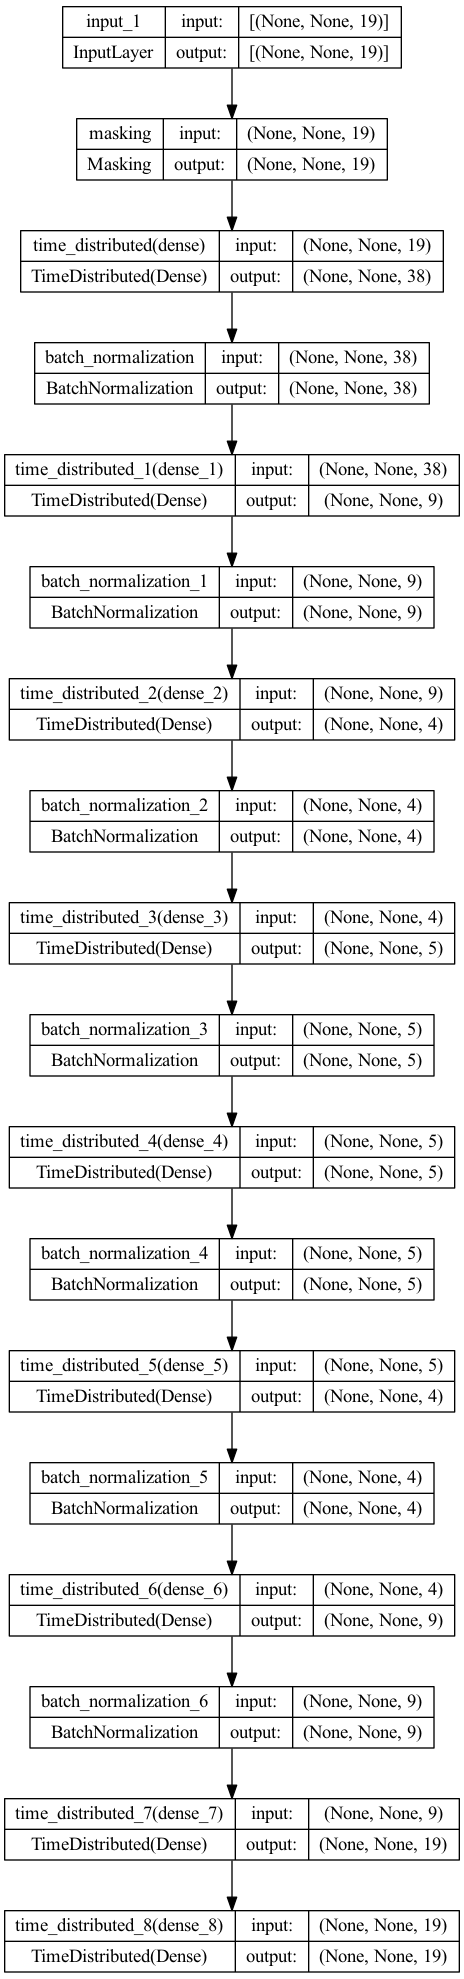

In [29]:
tf.keras.utils.plot_model(ParticleEncoder, "The Encoder.png", show_shapes = True)

In [39]:
# Split the data into training and validation sets.
X_train, X_valid, y_train, y_valid = train_test_split(
    Tracks_input_scaled, Standardized_Bhads_targets, train_size=0.7, random_state = 42)

In [40]:
# Split the data into training and validation sets.
X_train_b_jets, X_valid_b_jets, y_train_b_jets, y_valid_b_jets = train_test_split(
    b_jets_input_scaled, Standardized_Bhads_targets, train_size=0.7, random_state = 42)

In [32]:
# Introduce early_stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    min_delta=0.00001,  # The minimum amount of change to count as an improvement
    patience=50,  # The number of epochs to wait before stopping
    restore_best_weights=True,  # Keep the best weights
)
# Prevent spikes in the validation and training loss due to the gradient descent kicking the network out of a local minima
reduce_learn_on_plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.80, patience=15, min_lr=1e-9)

# Save the weights of the model to allow reuse in future.
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPointsDeepNet/AutoEncoderWeights&Biases.ckpt"
checkpoint_dir = os.path.dirname(path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_weights_only=True, verbose=0, save_freq = 100*BATCHSIZE)
#Timer
#cb = TimingCallback()

#Weight&Biases Callback:
#Wanda = WandbCallback(save_graph = True,save_weights_only = True, log_weights = True, log_gradients = True, log_evaluation = True, training_data = (X_train,y_train), validation_data = (X_valid,y_valid), log_batch_frequency = 5)

# Learning Scheduler:
exponential_decay_fn = DSNNA.expontial_decay(lr0 = LR,s = 100)
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [41]:
history_1 = ParticleEncoder.fit(
    X_train, X_train,
    validation_data= (X_valid, X_valid),
    epochs= 300,
    batch_size= BATCHSIZE,
     callbacks = [early_stopping, cp_callback, reduce_learn_on_plateau],
    )

Epoch 1/300
1058/1058 [==============================] - 8s 8ms/step - loss: 0.0071 - val_loss: 0.0070 - lr: 2.6214e-05
Epoch 2/300
 357/1058 [=========>....................] - ETA: 4s - loss: 0.0070

KeyboardInterrupt: 

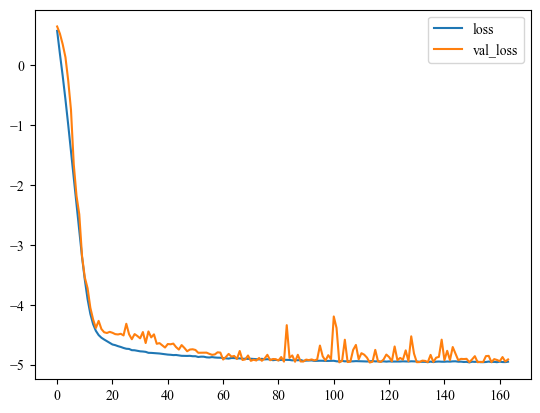

In [34]:
# Plot the loss and validation curves vs epoch
history_df = pd.DataFrame(history_1.history)
np.log(history_df.loc[:, ["loss","val_loss"]]).plot()
history_df.to_csv('/home/physics/phujdj/DeepLearningParticlePhysics/history.csv')

In [42]:
#Evaluate the entire performance of the model
loss = ParticleEncoder.evaluate(Tracks_input_scaled,Tracks_input_scaled,verbose = 2)
print("The TrackParticleEncoder has loss: ", loss)

3021/3021 - 4s - loss: 0.0066 - 4s/epoch - 1ms/step
The TrackParticleEncoder has loss:  0.006627953145653009


In [43]:
BParticleEncoder = JetEncoder(np.shape(b_jets_input_scaled)[1], 9)

In [44]:
BParticleEncoder.compile(
    loss = keras.losses.huber,
    optimizer = tf.keras.optimizers.Nadam(LR, use_ema = True),
)

In [45]:
print(BParticleEncoder.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 72)]              0         
                                                                 
 masking_2 (Masking)         (None, 72)                0         
                                                                 
 dense_22 (Dense)            (None, 72)                5256      
                                                                 
 batch_normalization_18 (Bat  (None, 72)               288       
 chNormalization)                                                
                                                                 
 dense_23 (Dense)            (None, 36)                2628      
                                                                 
 batch_normalization_19 (Bat  (None, 36)               144       
 chNormalization)                                          

In [ ]:
tf.keras.utils.plot_model(BParticleEncoder, "The Encoder.png", show_shapes = True)

In [46]:
history_2 = BParticleEncoder.fit(
    X_train_b_jets, X_train_b_jets,
    validation_data= (X_valid_b_jets, X_valid_b_jets),
    epochs= 300,
    batch_size= BATCHSIZE,
     callbacks = [early_stopping, cp_callback, reduce_learn_on_plateau],
    )

Epoch 1/300
1058/1058 [==============================] - 11s 4ms/step - loss: 0.2119 - val_loss: 0.1451 - lr: 1.0000e-04
Epoch 2/300
1058/1058 [==============================] - 4s 4ms/step - loss: 0.1296 - val_loss: 0.1257 - lr: 1.0000e-04
Epoch 3/300
1058/1058 [==============================] - 4s 4ms/step - loss: 0.1162 - val_loss: 0.1128 - lr: 1.0000e-04
Epoch 4/300
1058/1058 [==============================] - 4s 4ms/step - loss: 0.1060 - val_loss: 0.1032 - lr: 1.0000e-04
Epoch 5/300
1058/1058 [==============================] - 4s 4ms/step - loss: 0.0984 - val_loss: 0.0961 - lr: 1.0000e-04
Epoch 6/300
1058/1058 [==============================] - 4s 4ms/step - loss: 0.0917 - val_loss: 0.0887 - lr: 1.0000e-04
Epoch 7/300
1058/1058 [==============================] - 4s 4ms/step - loss: 0.0861 - val_loss: 0.0838 - lr: 1.0000e-04
Epoch 8/300
1058/1058 [==============================] - 4s 4ms/step - loss: 0.0819 - val_loss: 0.0810 - lr: 1.0000e-04
Epoch 9/300
1058/1058 [================

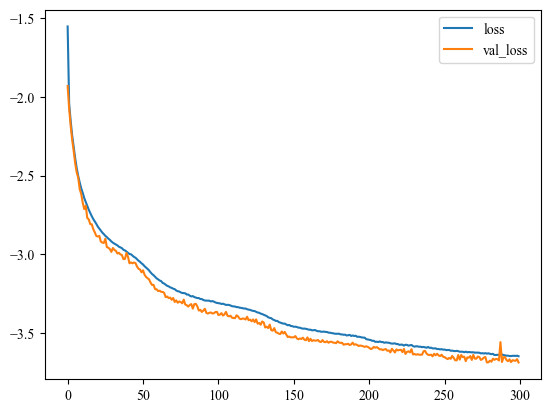

In [47]:
# Plot the loss and validation curves vs epoch
history_df_1 = pd.DataFrame(history_2.history)
np.log(history_df_1.loc[:, ["loss","val_loss"]]).plot()
history_df_1.to_csv('/home/physics/phujdj/DeepLearningParticlePhysics/history.csv')

In [50]:
#Evaluate the entire performance of the model
loss = BParticleEncoder.evaluate(b_jets_input_scaled,b_jets_input_scaled,verbose = 2)
print("The JetParticleEncoder has loss: ", loss)

3021/3021 - 3s - loss: 0.0231 - 3s/epoch - 840us/step
The JetParticleEncoder has loss:  0.023126270622015


In [48]:
ParticleEncoderTracksInput = keras.layers.Input(ParticleEncoder.layers[0].input_shape[0][1:])
ParticleEncoderTracks = ParticleEncoderTracksInput
for layer in ParticleEncoder.layers[1:9]:
    print(layer)
    ParticleEncoderTracks = layer(ParticleEncoderTracks)
ParticleEncoderTracks = keras.Model(inputs = ParticleEncoderTracksInput, outputs = ParticleEncoderTracks)

In [49]:
ParticleEncoderJetsInput = keras.layers.Input(BParticleEncoder.layers[0].input_shape[0][1:])
ParticleEncoderJets = ParticleEncoderJetsInput
for layer in BParticleEncoder.layers[1:9]:
    print(layer)
    ParticleEncoderJets = layer(ParticleEncoderJets)
ParticleEncoderJets = keras.Model(inputs = ParticleEncoderJetsInput, outputs = ParticleEncoderJets)

In [51]:
ParticleEncoderTracks.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, 19)]        0         
                                                                 
 masking (Masking)           (None, None, 19)          0         
                                                                 
 time_distributed (TimeDistr  (None, None, 38)         760       
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, None, 38)         152       
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, None, 9)          351       
 tributed)                                                       
                                                           

In [52]:
ParticleEncoderJets.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 72)]              0         
                                                                 
 masking_2 (Masking)         (None, 72)                0         
                                                                 
 dense_22 (Dense)            (None, 72)                5256      
                                                                 
 batch_normalization_18 (Bat  (None, 72)               288       
 chNormalization)                                                
                                                                 
 dense_23 (Dense)            (None, 36)                2628      
                                                                 
 batch_normalization_19 (Bat  (None, 36)               144       
 chNormalization)                                          

In [53]:
ParticleEncoderTracksClone = keras.models.clone_model(ParticleEncoderTracks)
ParticleEncoderTracksClone.set_weights(ParticleEncoderTracks.get_weights())

In [54]:
ParticleEncoderJetsClone = keras.models.clone_model(ParticleEncoderJets)
ParticleEncoderJetsClone.set_weights(ParticleEncoderJets.get_weights())

In [55]:
X_train_encoded = ParticleEncoderTracksClone.predict(X_train) 
X_valid_encoded = ParticleEncoderTracksClone.predict(X_valid)

907/907 [==============================] - 1s 927us/step


In [56]:
tracks_encoded = ParticleEncoderTracksClone.predict(Tracks_input_scaled)

3021/3021 [==============================] - 3s 997us/step


In [57]:
X_train_b_jets_encoded = ParticleEncoderJetsClone.predict(X_train_b_jets)
X_valid_b_jets_encoded = ParticleEncoderJetsClone.predict(X_valid_b_jets)

907/907 [==============================] - 1s 639us/step


In [58]:
jets_encoded = ParticleEncoderJetsClone.predict(b_jets_input_scaled)

3021/3021 [==============================] - 2s 653us/step


In [59]:
from sklearn.preprocessing import OneHotEncoder
bhadron_masses = []
for mass in bhads_m_clean:
    bhadron_masses.append([str(mass)])
print(np.shape(bhadron_masses))
encoder = OneHotEncoder(sparse = False)
onehot = encoder.fit_transform(bhadron_masses)
print(np.shape(onehot))

(96657, 1)
(96657, 12)


In [60]:
# Builds the deep neural network
track_layers = [20,30,40]
jet_layers = [250 for x in range(3)]
b_jets_layers = [20,30,40]

track_layers = [np.shape(tracks_encoded)[2]]+track_layers
print(track_layers)

#Initializers the optimizer used for training the network
optimizer = tf.keras.optimizers.Nadam(LR, use_ema=True)

#Build a DeepSets Projection Neural Network
DeepSetProjector = DeepSetsProjection(track_layers=track_layers, jet_layers=jet_layers, b_jet_layers=b_jets_layers, n_targets_classification=np.shape(onehot)[1], regularizer_strength = 1e-4, n_features = np.shape(jets_encoded)[1], n_targets=np.shape(bhads_targets)[1], Dropout_rate=0.1)

[5, 20, 30, 40]


In [ ]:
# Builds the deep neural network
track_layers = [16 for x in range(2)]
jet_layers = [256 for x in range(3)]
b_jets_layers = [16 for x in range(2)]

track_layers = [np.shape(Tracks_input_scaled)[2]]+track_layers
print(track_layers)
print(np.shape(onehot)[1])
#Initializers the optimizer used for training the network
optimizer = tf.keras.optimizers.Nadam(LR)

#Build a DeepSets Projection Neural Network
DeepSetProjector = DeepSetsProjection(track_layers=track_layers, b_jet_layers= b_jets_layers, jet_layers=jet_layers, n_targets=np.shape(Standardized_Bhads_targets)[1], n_targets_classification= np.shape(onehot)[1], regularizer_strength= 1e-6, n_features=np.shape(b_jets_input_scaled)[1], Dropout_rate=0.0001)

In [61]:
# Save the weights of the model to allow reuse in future.
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPointsDeepNet/ResidualDeepNetProjectorWeights&Biases.ckpt"
checkpoint_dir = os.path.dirname(path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_weights_only=True, verbose=0, save_freq = 50*BATCHSIZE)

In [62]:
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from HffragDeepSetsProjection import Multivariate_Gaussian_Negative_Likelihood_Loss_Curve
DeepSetProjector.compile(
 optimizer = optimizer,
 loss = {"MultivariateLoss": Multivariate_Gaussian_Negative_Likelihood_Loss_Curve, "MassOutput":tf.keras.losses.categorical_crossentropy},
 metrics = [Mean_Squared_Error]   
)

In [ ]:
bhads_targets

In [ ]:
DeepSetProjector.summary()

In [63]:
history  = DeepSetProjector.fit(
    (tracks_encoded, jets_encoded), y = {"MultivariateLoss":bhads_targets_clean, "MassOutput":onehot},
    validation_split = 0.3,
    epochs = EPOCHS,
    batch_size = BATCHSIZE,
    callbacks = [early_stopping, cp_callback, reduce_learn_on_plateau],
    )

Epoch 1/1000
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Use fn_output_signature instead
1058/1058 [==============================] - 36s 23ms/step - loss: 72.4531 - MultivariateLoss_loss: 39.5165 - MassOutput_loss: 1.5295 - MultivariateLoss_Mean_Squared_Error: 476.0299 - MassOutput_Mean_Squared_Error: 0.0603 - val_loss: 48.4504 - val_MultivariateLoss_loss: 18.1867 - val_MassOutput_loss: 1.4472 - val_MultivariateLoss_Mean_Squared_Error: 467.0605 - val_MassOutput_Mean_Squared_Error: 0.0589 - lr: 1.0000e-04
Epoch 2/1000
1058/1058 [==============================] - 23s 22ms/step - loss: 43.2486 - MultivariateLoss_loss: 13.9708 - MassOutput_loss: 1.4431 - MultivariateLoss_Mean_Squared_Error: 474.1856 - MassOutput_Mean_Squared_Error: 0.0589 - val_loss: 38.0015 - val_MultivariateLoss_loss: 9.4061 - val_MassOutp

KeyboardInterrupt: 

In [ ]:
# Plot the loss and validation curves vs epoch
history_df = pd.DataFrame(history.history)
np.log(history_df.loc[:, ["loss","val_loss"]]).plot()
history_df.to_csv('/home/physics/phujdj/DeepLearningParticlePhysics/history.csv')

In [ ]:
#Evaluate the entire performance of the model
loss = DeepSetProjector.evaluate((tracks_encoded, jets_encoded),(bhads_targets_clean, onehot),verbose = 2)
print("The Loaded DeepNet has loss: ", loss)

In [ ]:
mask = np.where(np.isinf(b_jets_input) == True)
b_jets_input_clean = np.delete(b_jets_input, mask, axis = 0)
print(b_jets_input_clean.shape)
Tracks_input_clean = np.delete(Tracks_input, mask, axis = 0)
bhads_m_clean = np.delete(bhads_m, mask, axis = 0)
bhads_targets_clean = np.delete(bhads_targets, mask, axis = 0) 
print(Tracks_input_clean.shape,b_jets_input_clean.shape,bhads_m_clean.shape, bhads_targets_clean.shape)

In [ ]:
Scaler_tracks = StandardScaler()
Num_events,Num_tracks,Num_features = np.shape(Tracks_input_clean)
Scaled_tracks = np.reshape(Tracks_input_clean, newshape=(-1,Num_features))
tracks_scaled = Scaler_tracks.fit_transform(Scaled_tracks)
Tracks_input_scaled = np.reshape(tracks_scaled, newshape= (Num_events,Num_tracks,Num_features))
print(np.shape(Tracks_input_scaled))

Scaler_jets = StandardScaler()
Num_events,Num_features = np.shape(b_jets_input_clean)
b_jets_scaled = np.reshape(b_jets_input_clean, newshape=(-1,Num_features))
b_jets_scaled = Scaler_jets.fit_transform(b_jets_scaled)
b_jets_input_scaled = np.reshape(b_jets_scaled, newshape= (Num_events,Num_features))
print(np.shape(b_jets_input_scaled))

means_2 = []
stds_2 = []
lister = []
for bhads_target_feature in range(np.shape(bhads_targets_clean)[1]):
    Bhads_targets = bhads_targets_clean[:,bhads_target_feature]
    mean, std = np.mean(Bhads_targets), np.std(Bhads_targets)
    means_2 = np.append(means_2,mean)
    stds_2 = np.append(stds_2,std)
    Standardized_Bhads_targets = (Bhads_targets - mean)/(std)
    Standardized_Bhads_targets = Standardized_Bhads_targets.reshape(-1,1)
    lister.append(Standardized_Bhads_targets)
Standardized_Bhads_targets_unmasked = np.concatenate(lister,axis = 1)
print(Standardized_Bhads_targets_unmasked.shape)
print(means_2,stds_2)

In [ ]:
tracks_encoded_unmasked = ParticleEncoderTracksClone.predict(Tracks_input_scaled)
jets_encoded_unmasked = ParticleEncoderJetsClone.predict(b_jets_input_scaled)
from sklearn.preprocessing import OneHotEncoder
bhadron_masses = []
for mass in bhads_m_clean:
    bhadron_masses.append([str(mass)])
print(np.shape(bhadron_masses))
encoder = OneHotEncoder(sparse = False)
onehot_unmasked = encoder.fit_transform(bhadron_masses)
print(np.shape(onehot_unmasked))

In [ ]:
tracks_encoded_unmasked = ParticleEncoderTracksClone.predict(Tracks_input_scaled)
jets_encoded_unmasked = ParticleEncoderJetsClone.predict(b_jets_input_scaled)

In [ ]:
#Evaluate the entire performance of the model
loss = DeepSetProjector.evaluate((tracks_encoded_unmasked, jets_encoded_unmasked),(bhads_targets_clean, onehot_unmasked),verbose = 2)
print("The Loaded DeepNet has loss: ", loss)

In [ ]:
predictions = DeepSetProjector.predict((tracks_encoded_unmasked, jets_encoded_unmasked))

In [ ]:
Predictions = np.stack([DeepSetProjector((tracks_encoded, jets_encoded))[0] for sample in range(100)])
Predictions = Predictions.mean(axis = 0)

In [ ]:
print(predictions[0].shape)
print(predictions[1].shape)
Predictions = predictions[0]
Predictions_Mass = predictions[1]

In [ ]:
lister = []
index = 0
predictions_x = Predictions[:,:11]
for bhads_features in range(np.shape(predictions_x)[1]):
    Predictions_temp = predictions_x[:, bhads_features]
    Predictions_temp = (Predictions_temp*stds_2[index]) + means_2[index]
    Predictions_temp = Predictions_temp.reshape(-1,1)
    lister.append(Predictions_temp)
    index+=1
Predictions_X = np.concatenate(lister, axis = 1)

In [ ]:
lister = []
index = 0
predictions_x_uncertainty = Predictions[:,11:22]
print(predictions_x_uncertainty)
for bhads_features in range(np.shape(predictions_x_uncertainty)[1]):
    Predictions_temp = predictions_x_uncertainty[:, bhads_features]
    Predictions_temp = (Predictions_temp*stds_2[index]) + means_2[index]
    Predictions_temp = Predictions_temp.reshape(-1,1)
    lister.append(Predictions_temp)
    index+=
Predictions_Uncertainty = np.concatenate(lister, axis = 1)
print(Predictions_Uncertainty)

In [ ]:
Error_px_unscaled = bhads_targets_clean[:,0] - Predictions_X[:,0]
Pull_bhads_px_unscaled = Error_px_unscaled/np.std(bhads_targets_clean[:,0])
Pull_px = Error_px_unscaled/Predictions_Uncertainty[:,0]

In [ ]:
Error_py_unscaled = bhads_targets_clean[:,1] - Predictions_X[:,1]
Pull_bhads_py_unscaled = Error_py_unscaled/np.std(bhads_targets_clean[:,1])
Pull_py = Error_py_unscaled/Predictions_Uncertainty[:,1]

In [ ]:
Error_pz_unscaled = bhads_targets_clean[:,2] - Predictions_X[:,2]
Pull_bhads_pz_unscaled = Error_pz_unscaled/np.std(bhads_targets_clean[:,2])
Pull_pz = Error_px_unscaled/Predictions_Uncertainty[:,2]

In [ ]:
Error_projection_unscaled = bhads_targets_clean[:,9] - Predictions_X[:,9]
Pull_bhads_projection_unscaled = Error_projection_unscaled/np.std(bhads_targets_clean[:,9])
Pull_projection = Error_projection_unscaled/Predictions_Uncertainty[:,9]

In [ ]:
Error_pxfraction_unscaled = bhads_targets_clean[:,3] - Predictions_X[:,3]
Pull_pxfraction_unscaled = Error_pxfraction_unscaled/np.std(bhads_targets_clean[:,3])
Pull_pxfraction = Error_pxfraction_unscaled/Predictions_Uncertainty[:,3]

In [ ]:
Error_pyfraction_unscaled = bhads_targets_clean[:,4] - Predictions_X[:,4]
Pull_pyfraction_unscaled = Error_pyfraction_unscaled/np.std(bhads_targets_clean[:,4])
Pull_pyfraction = Error_pyfraction_unscaled/Predictions_Uncertainty[:,4]

In [ ]:
Error_pzfraction_unscaled = bhads_targets_clean[:,5] - Predictions_X[:,5]
Pull_pzfraction_unscaled = Error_pzfraction_unscaled/np.std(bhads_targets_clean[:,5])
Pull_pzfraction = Error_pzfraction_unscaled/Predictions_Uncertainty[:,5]

In [ ]:
Error_energy_unscaled = bhads_targets_clean[:,6] - Predictions_X[:,6]
Pull_energy_unscaled = Error_energy_unscaled/np.std(bhads_targets_clean[:,6])
Pull_energy = Error_energy_unscaled/Predictions_Uncertainty[:,6]

In [ ]:
Error_mass_unscaled = bhads_targets_clean[:,10] - Predictions_X[:,10]
Pull_mass_unscaled = Error_mass_unscaled/np.std(bhads_targets_clean[:,10])
Pull_mass = Error_mass_unscaled/Predictions_Uncertainty[:,10]

In [ ]:
print(np.mean(Error_px_unscaled))
print(np.std(Error_px_unscaled))
binneddensity(Error_px_unscaled, fixedbinning(-20000,20000,100),xlabel = "Error_px_unscaled")

In [ ]:
print(np.mean(Pull_px))
print(np.std(Pull_px))
binneddensity(Pull_px, fixedbinning(-2,2,100),xlabel = "Pull_Px")

In [ ]:
print(np.mean(Error_py_unscaled))
print(np.std(Error_py_unscaled))
binneddensity(Error_py_unscaled, fixedbinning(-20000,20000,100),xlabel = "Error_py_unscaled")

In [ ]:
print(np.mean(Pull_py))
print(np.std(Pull_py))
binneddensity(Pull_py, fixedbinning(-2,2,100),xlabel = "Pull_Py")

In [ ]:
print(np.mean(Error_pz_unscaled))
print(np.std(Error_pz_unscaled))
binneddensity(Error_pz_unscaled, fixedbinning(-40000,40000,100),xlabel = "Error_pz_unscaled")

In [ ]:
print(np.mean(Pull_pz))
print(np.std(Pull_pz))
binneddensity(Pull_pz, fixedbinning(-2,2,100),xlabel = "Pull_Pz")

In [ ]:
print(np.mean(Error_projection_unscaled))
print(np.std(Error_projection_unscaled))
binneddensity(Error_projection_unscaled, fixedbinning(-1,1,100),xlabel = "Error_projection")

In [ ]:
print(np.mean(Pull_projection))
print(np.std(Pull_projection))
binneddensity(Pull_projection, fixedbinning(-1,1,100),xlabel = "Pull_projection")

In [ ]:
print(np.mean(Error_pxfraction_unscaled))
print(np.std(Error_pxfraction_unscaled))
binneddensity(Error_pxfraction_unscaled, fixedbinning(-1,1,100),xlabel = "Error_px_fraction")

In [ ]:
print(np.mean(Pull_pxfraction_unscaled))
print(np.std(Pull_pxfraction_unscaled))
binneddensity(Pull_pxfraction_unscaled, fixedbinning(-2,2,100),xlabel = "Pull_px_fraction")

In [ ]:
print(np.mean(Error_pyfraction_unscaled))
print(np.std(Error_pyfraction_unscaled))
binneddensity(Error_pyfraction_unscaled, fixedbinning(-1,1,100),xlabel = "Error_py_fraction")

In [ ]:
print(np.mean(Pull_pyfraction_unscaled))
print(np.std(Pull_pyfraction_unscaled))
binneddensity(Pull_pyfraction_unscaled, fixedbinning(-2,2,100),xlabel = "Pull_py_fraction")

In [ ]:
print(np.mean(Error_pzfraction_unscaled))
print(np.std(Error_pzfraction_unscaled))
binneddensity(Error_pzfraction_unscaled, fixedbinning(-1,1,100),xlabel = "Error_pz_fraction")

In [ ]:
print(np.mean(Pull_pzfraction_unscaled))
print(np.std(Pull_pzfraction_unscaled))
binneddensity(Pull_pzfraction_unscaled, fixedbinning(-1.5,1.5,100),xlabel = "Pull_pz_fraction")

In [ ]:
print(np.mean(Error_energy_unscaled))
print(np.std(Error_energy_unscaled))
binneddensity(Error_energy_unscaled, fixedbinning(-60000,60000,100),xlabel = "Error_energy")

In [ ]:
print(np.mean(Pull_energy_unscaled))
print(np.std(Pull_energy_unscaled))
binneddensity(Pull_energy_unscaled, fixedbinning(-1,1,100),xlabel = "Pull_energy_fraction")

In [ ]:
print(np.mean(Error_mass_unscaled))
print(np.std(Error_mass_unscaled))
binneddensity(Error_mass_unscaled, fixedbinning(-250,500,100),xlabel = "Mass Error")

In [ ]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,0]
y = Predictions_X[:,0]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "autumn",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "autumn", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,1]
y = Predictions_X[:,1]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "inferno",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "inferno", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Y momenta")
ax.set_xlabel("The true Y momenta of the tracks from each event")
ax.set_ylabel("The predicted Y momenta of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,2]
y = Predictions_X[:,2]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "winter",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "winter", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Z momenta")
ax.set_xlabel("The true Z momenta of the tracks from each event")
ax.set_ylabel("The predicted Z momenta of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,3]
y = Predictions_X[:,3]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "spring",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "spring", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred X momenta fraction")
ax.set_xlabel("The true X momenta fraction of the tracks from each event")
ax.set_ylabel("The predicted X fraction of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,4]
y = Predictions_X[:,4]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "gist_heat",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "gist_heat", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Y momenta fraction")
ax.set_xlabel("The true Y momenta fraction of the tracks from each event")
ax.set_ylabel("The predicted Y fraction of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,5]
y = Predictions_X[:,5]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "summer",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "summer", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Z momenta fraction")
ax.set_xlabel("The true Z momenta fraction of the tracks from each event")
ax.set_ylabel("The predicted Z fraction of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,9]
y = Predictions_X[:,9]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "PiYG",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "PiYG", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Bhadron Projection")
ax.set_xlabel("The true Bhadron Projection of the tracks from each event")
ax.set_ylabel("The predicted Bhadron Projection of b hadron jets")

In [ ]:
fig, ax = plt.subplots(figsize = (12,12))
x = Predictions_X[:,6]
y = bhads_targets_clean[:,6]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "Spectral",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "Spectral", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred B-hadron Energy")
ax.set_xlabel("The true B-hadron Energy of the tracks from each event")
ax.set_ylabel("The predicted B-hadron Energy of b hadron jets")

In [ ]:
print(Predictions_X[:5,10])
print(bhads_targets_clean[:5,10])

In [ ]:
fig, ax = plt.subplots(figsize = (12,12))
x = Predictions_X[:,10]
y = bhads_targets_clean[:,10]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "Spectral",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "Spectral", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred B-hadron Mass")
ax.set_xlabel("The true B-hadron Mass of the tracks from each event")
ax.set_ylabel("The predicted B-hadron Mass of b hadron jets")